In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import loguniform 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
from tqdm import tqdm

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform=transform
test_dataset.transform=transform

m=len(train_dataset)

In [ ]:
#random_split randomly split a dataset into non-overlapping new datasets of given lengths
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

print("Batches in Train Loader: {}".format(len(train_loader)))
print("Batches in Valid Loader: {}".format(len(valid_loader)))
print("Batches in Test Loader: {}".format(len(test_loader)))

print("Examples in Train Loader: {}".format(len(train_loader.sampler)))
print("Examples in Valid Loader: {}".format(len(valid_loader.sampler)))
print("Examples in Test Loader: {}".format(len(test_loader.sampler)))

Batches in Train Loader: 375
Batches in Valid Loader: 94
Batches in Test Loader: 79
Examples in Train Loader: 48000
Examples in Valid Loader: 12000
Examples in Test Loader: 10000


In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Sandal, Trouser, Pullover, Coat, Ankle Boot, Trouser, Sneaker, Coat, Sneaker, Dress, 

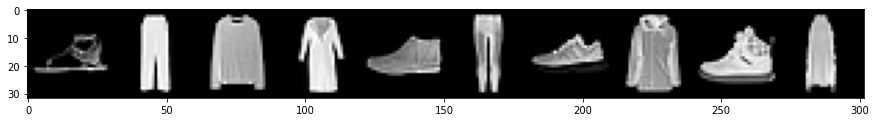

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

Define CNN architecture

In [ ]:
class CNN(nn.Module):
    '''
    Module including network structure and functioning, basic training, testing and validating operations.
    '''
    def __init__(self, n_channels, pdrop2d, pdrop1d):
        '''
        The network is composed of:
        - one convolutional layer with 1 input channel, @n_channels output channels, a 3 by 3 kernel 
        - another convolutional layer with @n_channels input channels, 2*@n_channels output channels, 5 by 5 kernel
        - a dropout layer
        - one fully connected layer with (img size)x(2*n_channels)=50xn_channels inputs, 100 outputs
        - another dropout layer
        - one fully connected layer with 100 inputs, 10 outputs (corresponding to the 10 labels)  
        
        Input
        n_channels: number of convolutional channels
        pdrop2d:    dropout probability of 2D dropout layer
        pdrop1d:    dropout probability of 1D dropout layer
        '''
        super(CNN, self).__init__()
    
        # --> img size = 28-3+2*1+1= 28x28 
        self.conv1 = nn.Conv2d(1, n_channels, kernel_size=3, padding=1)
        self.mpool = nn.MaxPool2d(2, 2)    
        # dropout layer
        self.drop2 = nn.Dropout2d(p=pdrop2d) 
        self.conv2 = nn.Conv2d(n_channels, 2*n_channels, kernel_size=5) 
        
        # fully connceted layer with (img size)x(2*n_channels)=50xn_channels, 100 output units
        self.fulc1 = nn.Linear(50*n_channels, 100)             
        # dropout after first linear layer
        self.drop1 = nn.Dropout(p=pdrop1d)
        # fully connected layer with inputs equal to number of outputs of previous layer, 10 outputs (10 digits)
        self.fulc2 = nn.Linear(100, 10)
        
        print('Network initialized')

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.mpool(x)
        x = F.relu(self.conv2(x))
        x = self.mpool(x)
        x = self.drop2(x)
        x = x.view(x.size(0), -1) # reshaping necessary for linear layer
        x = F.relu(self.fulc1(x))
        x = self.drop1(x)
        x = self.fulc2(x)
        
        return x
    
    def train_step(self, train_loader, optimizer, loss_func, device, epoch, verbose=False):
        """
        Define the basic train step.
        
        train_loader: dataloader
        optimizer:    type of selected optimizer (SGD, Adam...)
        loss_func:    selected loss function
        device:       gpu (if available) or cpu
        epoch:        number of epoch in training process
        verbose:      if True prints out status of training process, default False
        
        Return: training loss.
        """
        
        train_loss = [] #initialize vector containing training losses
        self.train()    #set training mode
        
        for ii, s_batch in enumerate(train_loader):
            
            x_batch = s_batch[0].to(device)       #import data, move to device 
            label_b = s_batch[1].to(device)       #import labels, move to device
            
            for_out = self.forward(x_batch)       #forward pass
            
            tr_loss = loss_func(for_out, label_b) #compute loss
        
            self.zero_grad()                      #back-propagation
            tr_loss.backward()
            
            optimizer.step()                      #weights update
                
            ba_loss = tr_loss.detach().cpu().numpy()
            train_loss.append(ba_loss)            #save loss for batch
            
            if (ii % 10 == 0 and verbose): # every 10 batches print out a sumary of training results
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, ii * len(s_batch[0]), len(train_loader.dataset),
                    100. * ii / len(train_loader), ba_loss))

        return train_loss
    
    
    def val_step(self, valid_loader, loss_func, device):
        """
        Define basic validation step.
        
        valid_loader: dataloader
        loss_func:    selected loss function
        device:       gpu (if available) or cpu
        
        Return: validation loss, validation accuracy.
        """
        val_loss = [] #initialize vector containing validation losses
        self.eval()   #set evaluation mode
        
        with torch.no_grad():                         #disable gradient tracking
            for s_batch in valid_loader:
                
                x_batch = s_batch[0].to(device)       #import data, move to device
                label_b = s_batch[1].to(device)       #import labels, move to device
            
                for_out = self.forward(x_batch)       #forward pass

                va_loss = loss_func(for_out, label_b) #compute loss

                ba_loss = va_loss.detach().cpu().numpy()
                val_loss.append(ba_loss)           #save loss for batch
        
        return val_loss
    
    def fitting(self, train_loader, val_loader, optimizer, loss_func, verbose, param):
        '''
        Define training process.
        
        train_loader: train set dataloader 
        valid_loader: validation set dataloader
        optimizer:    selected optimizer 
        loss_func:    selected loss function
        verbose:      if True prints out training status during training process
        param:        dictionary containing the rest of the parameters
        
        Return: train and validation losses.
        '''
        
        train_loss_log = [] 
        val_loss_log = []
        
        for epoch in tqdm(range(param['num_epochs'])):
            # Training
            train_loss = self.train_step(train_loader, optimizer, loss_func, 
                                         param['device'], epoch, verbose)
                
            # Compute and store average training loss
            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)
            
            # Validation 
            valid_loss = self.val_step(val_loader, loss_func, param['device'])
            
            # Compute and store average validation loss
            valid_loss = np.mean(valid_loss)
            val_loss_log.append(valid_loss)
            
            # Check for early stopping condition
            stop = self._early_stopping(val_loss_log, param['num_epochs'])
            if stop: 
                print('Early stopping at epoch ', epoch)
                param['num_epochs'] = epoch
                break
            
        return train_loss_log, val_loss_log
    
    def predicting(self, data_loader, device):
        '''
        Compute and returns predicted labels.
        '''              
                
        predicts = [] #initialize vector containing predictions
        self.eval()   #set evaluation mode
        
        with torch.no_grad():                   #disable gradient tracking
            for s_batch in tqdm(data_loader):
                
                x_batch = s_batch[0].to(device) #import data, move to device
                
                for_out = self.forward(x_batch) #forward pass

                outputs = for_out.cpu().numpy().argmax()
                predicts.append(outputs)        #save predictions
        
        return np.array(predicts)
                    
    def _early_stopping(self, val_loss_log, num_epochs):
        
        stop = False
        
        if len(val_loss_log)>1:
            # set interval dimension in which to check loss values
            range_loss = min(len(val_loss_log), 10)
            last_loss = val_loss_log[-1]
            mean_loss = np.mean(val_loss_log[-range_loss:-1])
            
            if (np.abs(last_loss-mean_loss) < 0.005): 
                stop = True
                
        return stop

Random parameters selection

In [ ]:
# Initial parameters
n_epochs = 15
batch_size_train = 192
batch_size_test = 1000
learning_rate = 0.002
momentum = 0.9

In [ ]:
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

params = {"device"        : [device],
          "num_epochs"    : [n_epochs],
          "n_channels"    : np.arange(3,11), 
          "pdrop1d"       : np.random.uniform(0, 0.25, 20),
          "pdrop2d"       : np.random.uniform(0, 0.25, 20),
          "optimizer"     : ['sgd', 'adam'],
          "momentum"      : np.random.uniform(0.5, 0.95, 20),
          "learning_rate" : loguniform.rvs(1e-5, 1e-2, size=20),
          "reg_param"     : loguniform.rvs(1e-4, 1e-1, size=20),
          }

print('Random network parameters:', random_params(params))

Training device: cuda
Random network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 9, 'pdrop1d': 0.1662857764109922, 'pdrop2d': 0.01798865883302317, 'optimizer': 'adam', 'momentum': 0.5872612195455301, 'learning_rate': 0.004449159915432177, 'reg_param': 0.0004986624637438257}


Selecting the best model with random search

In [ ]:
def random_search(grid_pars, train_loader, valid_loader, n_models):
    '''
    Random parameter search for selecting optimal network
    
    grid_pars    : dictionary containing all the parameters on which to perform the random search
    train_loader : dataloader for training set
    valid_loader : dataloader for validation set
    n_models     : number of models tested, i.e. number of iterations 
    
    Returns: train and validation losses and network parameters
    '''
    
    # initialise outputs
    net_params = []
    train_loss_log = []
    val_loss_log = []
    
    verbose = False # we don't need intermediate training steps
    
    for i in tqdm(range(n_models)):
        
        # select random parameters
        params = random_params(grid_pars)
        
        print('Model ', i+1)
        print('Network parameters:', params)
        
        # initialize network
        net = CNN(params['n_channels'], params['pdrop2d'], params['pdrop1d'] )
        net.to(params['device'])
        
        # initialize loss function
        loss_func = nn.CrossEntropyLoss() 
        # set up optimizer
        if params['optimizer']=='adam':
            optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'], 
                             weight_decay=params['reg_param'])
        elif params['optimizer']=='sgd':
            optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], 
                            momentum=params['momentum'], weight_decay=params['reg_param'])
        
        # training & validation process
        train_loss, valid_loss = net.fitting(train_loader, valid_loader, optimizer, 
                                             loss_func, verbose, params)
        
        train_loss_log.append(train_loss)
        val_loss_log.append(valid_loss)
        
        # append final to parameter dictionnary  final loss for each model studied
        params['final_loss'] = valid_loss[-1]
        net_params.append(params)
        
    return net_params, train_loss_log, val_loss_log

In [ ]:
# perform random search!
net_params, train_loss_rs, valid_loss_rs = random_search(params, train_loader, valid_loader, 15)

  0%|          | 0/15 [00:00<?, ?it/s]

Model  1
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 9, 'pdrop1d': 0.1662857764109922, 'pdrop2d': 0.14656503063798654, 'optimizer': 'adam', 'momentum': 0.626704227631114, 'learning_rate': 0.003197594206352734, 'reg_param': 0.0004986624637438257}
Network initialized



  7%|▋         | 1/15 [02:36<36:32, 156.63s/it]

Model  2
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.08090877273778954, 'pdrop2d': 0.2134587302306889, 'optimizer': 'sgd', 'momentum': 0.8897704872425243, 'learning_rate': 0.0007969292931474134, 'reg_param': 0.0004509254414130406}
Network initialized



 13%|█▎        | 2/15 [04:56<31:48, 146.79s/it]

Model  3
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 10, 'pdrop1d': 0.08402821083910789, 'pdrop2d': 0.019516973867168386, 'optimizer': 'adam', 'momentum': 0.8910789150109428, 'learning_rate': 1.0838529055446877e-05, 'reg_param': 0.0017437632477293418}
Network initialized



 20%|██        | 3/15 [07:21<29:11, 145.96s/it]

Model  4
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 10, 'pdrop1d': 0.1707072062565491, 'pdrop2d': 0.10450410944000538, 'optimizer': 'adam', 'momentum': 0.8884650256131368, 'learning_rate': 0.0021585403505821684, 'reg_param': 0.021622974746968053}
Network initialized



 27%|██▋       | 4/15 [09:23<25:02, 136.57s/it]

Early stopping at epoch  12
Model  5
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 4, 'pdrop1d': 0.059557485606310634, 'pdrop2d': 0.07532029478862792, 'optimizer': 'adam', 'momentum': 0.7262582458856524, 'learning_rate': 0.00018729531117450956, 'reg_param': 0.0005931909388418126}
Network initialized



 33%|███▎      | 5/15 [11:38<22:38, 135.90s/it]

Model  6
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 9, 'pdrop1d': 0.1707072062565491, 'pdrop2d': 0.05628865952033618, 'optimizer': 'adam', 'momentum': 0.6344674798471595, 'learning_rate': 0.001951997628780558, 'reg_param': 0.0003254975021553702}
Network initialized



 40%|████      | 6/15 [13:56<20:31, 136.79s/it]

Model  7
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.15695699083843337, 'pdrop2d': 0.08413067114148787, 'optimizer': 'adam', 'momentum': 0.856313748533497, 'learning_rate': 0.0007969292931474134, 'reg_param': 0.021622974746968053}
Network initialized



 47%|████▋     | 7/15 [15:53<17:21, 130.23s/it]

Early stopping at epoch  12
Model  8
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 4, 'pdrop1d': 0.0343830825447102, 'pdrop2d': 0.10450410944000538, 'optimizer': 'adam', 'momentum': 0.5178889291423902, 'learning_rate': 1.0838529055446877e-05, 'reg_param': 0.0008358762617355274}
Network initialized



 53%|█████▎    | 8/15 [18:06<15:16, 130.99s/it]

Model  9
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 10, 'pdrop1d': 0.13093053523657242, 'pdrop2d': 0.13820053388121864, 'optimizer': 'adam', 'momentum': 0.626704227631114, 'learning_rate': 0.00018729531117450956, 'reg_param': 0.001989943766842918}
Network initialized



 60%|██████    | 9/15 [20:25<13:22, 133.73s/it]

Model  10
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 5, 'pdrop1d': 0.24047664880891598, 'pdrop2d': 0.08413067114148787, 'optimizer': 'adam', 'momentum': 0.626704227631114, 'learning_rate': 0.0007969292931474134, 'reg_param': 0.0008358762617355274}
Network initialized



 67%|██████▋   | 10/15 [22:40<11:09, 133.86s/it]

Model  11
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 5, 'pdrop1d': 0.08090877273778954, 'pdrop2d': 0.14727526373532676, 'optimizer': 'sgd', 'momentum': 0.626704227631114, 'learning_rate': 1.0838529055446877e-05, 'reg_param': 0.001989943766842918}
Network initialized



 73%|███████▎  | 11/15 [22:57<06:33, 98.27s/it] 

Early stopping at epoch  1
Model  12
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.22073095156092878, 'pdrop2d': 0.01997201474010349, 'optimizer': 'sgd', 'momentum': 0.777375344139875, 'learning_rate': 2.2871923492605465e-05, 'reg_param': 0.0004986624637438257}
Network initialized



 80%|████████  | 12/15 [23:15<03:41, 73.76s/it]

Early stopping at epoch  1
Model  13
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 6, 'pdrop1d': 0.15695699083843337, 'pdrop2d': 0.10450410944000538, 'optimizer': 'sgd', 'momentum': 0.7262582458856524, 'learning_rate': 0.002032404762362631, 'reg_param': 0.001989943766842918}
Network initialized



 87%|████████▋ | 13/15 [25:28<03:03, 91.58s/it]

Model  14
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 5, 'pdrop1d': 0.1513858862496674, 'pdrop2d': 0.11209982822314316, 'optimizer': 'sgd', 'momentum': 0.9356495937336917, 'learning_rate': 0.000520382608005761, 'reg_param': 0.0017437632477293418}
Network initialized



 93%|█████████▎| 14/15 [27:40<01:43, 103.84s/it]

Model  15
Network parameters: {'device': device(type='cuda'), 'num_epochs': 15, 'n_channels': 9, 'pdrop1d': 0.013549028493914594, 'pdrop2d': 0.07532029478862792, 'optimizer': 'sgd', 'momentum': 0.6599246595804791, 'learning_rate': 0.000520382608005761, 'reg_param': 0.0015189658285122115}
Network initialized



100%|██████████| 15/15 [29:56<00:00, 119.74s/it]


<Figure size 432x288 with 0 Axes>

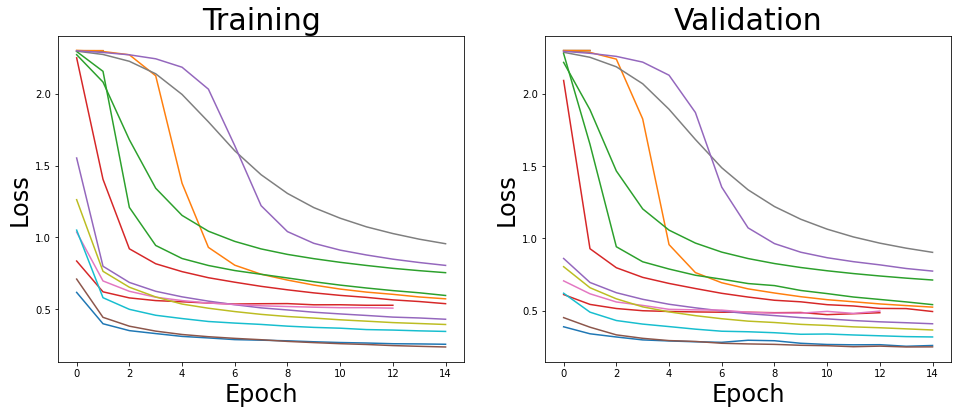

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

for tr_l in train_loss_rs:
    ax[0].plot(tr_l)
    
ax[0].set_ylabel('Loss', fontsize=24)
ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_title('Training', fontsize=30)

for val in valid_loss_rs:
    ax[1].plot(val)
    
ax[1].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_title('Validation', fontsize=30)

plt.savefig('FashionMNIST_tr_val_loss.png')
plt.show()

<Figure size 432x288 with 0 Axes>

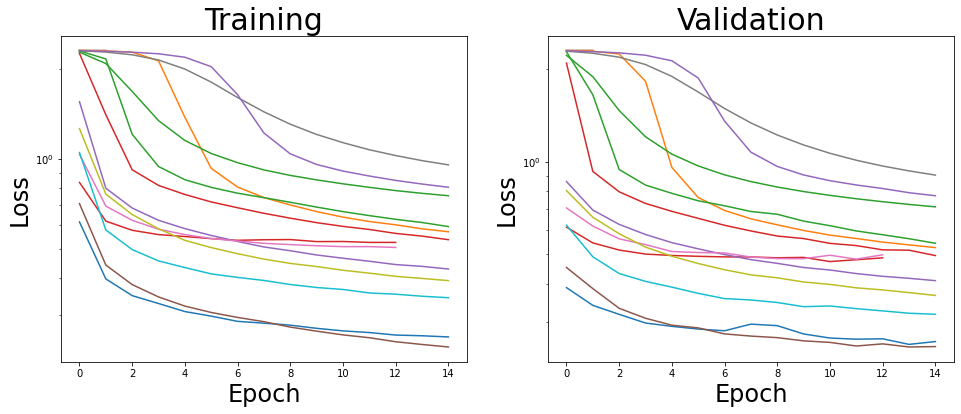

In [ ]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

for tr_l in train_loss_rs:
    ax[0].semilogy(tr_l)
    
ax[0].set_ylabel('Loss', fontsize=24)
ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_title('Training', fontsize=30)

for val in valid_loss_rs:
    ax[1].semilogy(val)
    
ax[1].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_title('Validation', fontsize=30)

plt.savefig('FashionMNIST_tr_val_loss_log.png')
plt.show()

In [ ]:
avg_val_loss = [np.mean(vl) for vl in valid_loss_rs]
min_val_loss = [vl[-1] for vl in valid_loss_rs]
print('Minimum average validation losses (top 10):', np.sort(avg_val_loss)[:10])
print(np.argmin(avg_val_loss))
print(np.argmin(min_val_loss))

Minimum average validation losses (top 10): [0.29165184 0.29315633 0.38317662 0.47580615 0.5036897  0.5231301
 0.528465   0.7227259  0.8573034  1.0455825 ]
0
5


In [ ]:
for i, pars in enumerate(net_params):
    pars['avg_train_loss'] = np.mean(train_loss_rs[i])
    pars['avg_valid_loss'] = np.mean(valid_loss_rs[i])
    pars.pop('device')   # remove device parameter before saving the grid search results
    for k in pars.keys():
        if k!= 'optimizer':
            pars[k] = float(pars[k]) 

print(net_params)

[{'num_epochs': 15.0, 'n_channels': 9.0, 'pdrop1d': 0.1662857764109922, 'pdrop2d': 0.14656503063798654, 'optimizer': 'adam', 'momentum': 0.626704227631114, 'learning_rate': 0.003197594206352734, 'reg_param': 0.0004986624637438257, 'final_loss': 0.25950103998184204, 'avg_train_loss': 0.31442153453826904, 'avg_valid_loss': 0.2916518449783325}, {'num_epochs': 15.0, 'n_channels': 6.0, 'pdrop1d': 0.08090877273778954, 'pdrop2d': 0.2134587302306889, 'optimizer': 'sgd', 'momentum': 0.8897704872425243, 'learning_rate': 0.0007969292931474134, 'reg_param': 0.0004509254414130406, 'final_loss': 0.5248467326164246, 'avg_train_loss': 1.1487579345703125, 'avg_valid_loss': 1.0455825328826904}, {'num_epochs': 15.0, 'n_channels': 10.0, 'pdrop1d': 0.08402821083910789, 'pdrop2d': 0.019516973867168386, 'optimizer': 'adam', 'momentum': 0.8910789150109428, 'learning_rate': 1.0838529055446877e-05, 'reg_param': 0.0017437632477293418, 'final_loss': 0.7124173641204834, 'avg_train_loss': 1.1417218446731567, 'avg_v

Select best net

In [ ]:
best_net = net_params[np.argmin([i['avg_valid_loss'] for i in net_params])]
print('Best network parameters:', best_net)

Best network parameters: {'num_epochs': 15.0, 'n_channels': 9.0, 'pdrop1d': 0.1662857764109922, 'pdrop2d': 0.14656503063798654, 'optimizer': 'adam', 'momentum': 0.626704227631114, 'learning_rate': 0.003197594206352734, 'reg_param': 0.0004986624637438257, 'final_loss': 0.25950103998184204, 'avg_train_loss': 0.31442153453826904, 'avg_valid_loss': 0.2916518449783325}


Test final_net performances

In [ ]:
# use full train set to train, test set to validate model
train_loader_all = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

# initialize network
final_net = CNN(int(best_net['n_channels']), best_net['pdrop2d'], best_net['pdrop1d'] )
final_net.to(device)
        
# initialize loss function
loss_func = nn.CrossEntropyLoss() 

# set up optimizer
if best_net['optimizer']=='adam':
    optimizer = optim.Adam(final_net.parameters(), lr=best_net['learning_rate'], 
                     weight_decay=best_net['reg_param'])
elif best_net['optimizer']=='sgd':
    optimizer = optim.SGD(final_net.parameters(), lr=best_net['learning_rate'], 
                    momentum=best_net['momentum'], weight_decay=best_net['reg_param'])
    
best_net['num_epochs'] = 30
best_net['device'] = device
verbose = True # see training process checkpoints

# Training and testing
best_train_loss, best_test_loss = final_net.fitting(train_loader_all, test_loader, optimizer,
                                                    loss_func, verbose, best_net)

Network initialized


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308060
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.567408
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.982205
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.977561
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.775772
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.741803
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.663177
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.674195
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.690433
Train Epoch: 1 [17280/60000 (29%)]	Loss: 0.589582
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.606409
Train Epoch: 1 [21120/60000 (35%)]	Loss: 0.624775
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.516269
Train Epoch: 1 [24960/60000 (42%)]	Loss: 0.532731
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.450809
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.568819
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.593218
Train Epoch: 1 [32640/60000 (54%)]	Loss: 0.516442
Train Epoch: 1 [34560/60000 (58%)]	Loss: 0.630211
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.413588
Train Epoch:

  3%|▎         | 1/30 [00:11<05:21, 11.07s/it]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.381602
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.446562
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.404537
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.402520
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.392052
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.513614
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.473770
Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.551902
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.481308
Train Epoch: 2 [17280/60000 (29%)]	Loss: 0.544106
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.438494
Train Epoch: 2 [21120/60000 (35%)]	Loss: 0.555067
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.425972
Train Epoch: 2 [24960/60000 (42%)]	Loss: 0.351582
Train Epoch: 2 [26880/60000 (45%)]	Loss: 0.496635
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.330985
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.495650
Train Epoch: 2 [32640/60000 (54%)]	Loss: 0.417849
Train Epoch: 2 [34560/60000 (58%)]	Loss: 0.387418
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.416824
Train Epoch:

  7%|▋         | 2/30 [00:22<05:08, 11.03s/it]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.376707
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.476104
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.393574
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.382794
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.335918
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.267573
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.322815
Train Epoch: 3 [13440/60000 (22%)]	Loss: 0.357021
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.424893
Train Epoch: 3 [17280/60000 (29%)]	Loss: 0.410587
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.353500
Train Epoch: 3 [21120/60000 (35%)]	Loss: 0.526589
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.329917
Train Epoch: 3 [24960/60000 (42%)]	Loss: 0.401552
Train Epoch: 3 [26880/60000 (45%)]	Loss: 0.331344
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.323583
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.295335
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.353284
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.441992
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.331860
Train Epoch:

 10%|█         | 3/30 [00:33<04:57, 11.03s/it]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.308996
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.277448
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.331845
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.427128
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.327648
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.340984
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.364693
Train Epoch: 4 [13440/60000 (22%)]	Loss: 0.470541
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.370799
Train Epoch: 4 [17280/60000 (29%)]	Loss: 0.389045
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.340723
Train Epoch: 4 [21120/60000 (35%)]	Loss: 0.381120
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.327561
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.213195
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.360193
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.268064
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.308536
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.321509
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.227788
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.250474
Train Epoch:

 13%|█▎        | 4/30 [00:44<04:46, 11.03s/it]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.219404
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.328028
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.272179
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.358809
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.334309
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.258884
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.320403
Train Epoch: 5 [13440/60000 (22%)]	Loss: 0.310025
Train Epoch: 5 [15360/60000 (26%)]	Loss: 0.325405
Train Epoch: 5 [17280/60000 (29%)]	Loss: 0.400001
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.361540
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.317081
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.271922
Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.284460
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.195433
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.317618
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.347856
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.328631
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.243990
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.327401
Train Epoch:

 17%|█▋        | 5/30 [00:55<04:36, 11.04s/it]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.318125
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.292372
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.328521
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.279677
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.298055
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.362663
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.321169
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.259705
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.304428
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.289028
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.400351
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.294776
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.317460
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.284950
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.397668
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.434451
Train Epoch: 6 [30720/60000 (51%)]	Loss: 0.372370
Train Epoch: 6 [32640/60000 (54%)]	Loss: 0.272008
Train Epoch: 6 [34560/60000 (58%)]	Loss: 0.392788
Train Epoch: 6 [36480/60000 (61%)]	Loss: 0.343421
Train Epoch:

 20%|██        | 6/30 [01:07<04:32, 11.34s/it]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.269159
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.254330
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.325397
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.282572
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.224521
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.249298
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.263717
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.315268
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.296129
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.347573
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.329084
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.328918
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.256899
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.300784
Train Epoch: 7 [26880/60000 (45%)]	Loss: 0.271555
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.313811
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.264642
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.217263
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.338742
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.289085
Train Epoch:

 23%|██▎       | 7/30 [01:18<04:17, 11.21s/it]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.239159
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.248475
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.375716
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.349115
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.331515
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.291736
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.330981
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.336050
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.214553
Train Epoch: 8 [17280/60000 (29%)]	Loss: 0.330893
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.240225
Train Epoch: 8 [21120/60000 (35%)]	Loss: 0.311100
Train Epoch: 8 [23040/60000 (38%)]	Loss: 0.344537
Train Epoch: 8 [24960/60000 (42%)]	Loss: 0.369079
Train Epoch: 8 [26880/60000 (45%)]	Loss: 0.342548
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.259080
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.244396
Train Epoch: 8 [32640/60000 (54%)]	Loss: 0.366888
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.307823
Train Epoch: 8 [36480/60000 (61%)]	Loss: 0.389799
Train Epoch:

 27%|██▋       | 8/30 [01:28<04:04, 11.11s/it]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.297022
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.308848
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.309022
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.193744
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.278193
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.239323
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.266282
Train Epoch: 9 [13440/60000 (22%)]	Loss: 0.249762
Train Epoch: 9 [15360/60000 (26%)]	Loss: 0.341351
Train Epoch: 9 [17280/60000 (29%)]	Loss: 0.350670
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.217000
Train Epoch: 9 [21120/60000 (35%)]	Loss: 0.235404
Train Epoch: 9 [23040/60000 (38%)]	Loss: 0.233706
Train Epoch: 9 [24960/60000 (42%)]	Loss: 0.232502
Train Epoch: 9 [26880/60000 (45%)]	Loss: 0.343494
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.376642
Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.356044
Train Epoch: 9 [32640/60000 (54%)]	Loss: 0.251794
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.244385
Train Epoch: 9 [36480/60000 (61%)]	Loss: 0.212073
Train Epoch:

 30%|███       | 9/30 [01:39<03:52, 11.05s/it]

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.296793
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.305906
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.252876
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.286638
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.301867
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.276900
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.307376
Train Epoch: 10 [13440/60000 (22%)]	Loss: 0.356153
Train Epoch: 10 [15360/60000 (26%)]	Loss: 0.234353
Train Epoch: 10 [17280/60000 (29%)]	Loss: 0.341515
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.300843
Train Epoch: 10 [21120/60000 (35%)]	Loss: 0.293701
Train Epoch: 10 [23040/60000 (38%)]	Loss: 0.293877
Train Epoch: 10 [24960/60000 (42%)]	Loss: 0.280534
Train Epoch: 10 [26880/60000 (45%)]	Loss: 0.305823
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.294555
Train Epoch: 10 [30720/60000 (51%)]	Loss: 0.312812
Train Epoch: 10 [32640/60000 (54%)]	Loss: 0.236955
Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.213464
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0

 33%|███▎      | 10/30 [01:50<03:40, 11.01s/it]

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.349846
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.259048
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.208856
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.226652
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.321519
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.280052
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.257466
Train Epoch: 11 [13440/60000 (22%)]	Loss: 0.316390
Train Epoch: 11 [15360/60000 (26%)]	Loss: 0.199280
Train Epoch: 11 [17280/60000 (29%)]	Loss: 0.315792
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.366084
Train Epoch: 11 [21120/60000 (35%)]	Loss: 0.345604
Train Epoch: 11 [23040/60000 (38%)]	Loss: 0.271884
Train Epoch: 11 [24960/60000 (42%)]	Loss: 0.304850
Train Epoch: 11 [26880/60000 (45%)]	Loss: 0.351831
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.355372
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.268384
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.378002
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.294490
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0

 37%|███▋      | 11/30 [02:01<03:28, 10.96s/it]

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.331709
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.258764
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.190856
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.245839
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.333063
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.268711
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.290820
Train Epoch: 12 [13440/60000 (22%)]	Loss: 0.275901
Train Epoch: 12 [15360/60000 (26%)]	Loss: 0.313850
Train Epoch: 12 [17280/60000 (29%)]	Loss: 0.239356
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.202741
Train Epoch: 12 [21120/60000 (35%)]	Loss: 0.355181
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.280020
Train Epoch: 12 [24960/60000 (42%)]	Loss: 0.318709
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.273472
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.287728
Train Epoch: 12 [30720/60000 (51%)]	Loss: 0.227019
Train Epoch: 12 [32640/60000 (54%)]	Loss: 0.352609
Train Epoch: 12 [34560/60000 (58%)]	Loss: 0.354807
Train Epoch: 12 [36480/60000 (61%)]	Loss: 0

 40%|████      | 12/30 [02:12<03:17, 10.97s/it]

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.295190
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.296991
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.257279
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.264819
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.266597
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.208243
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.285345
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.281917
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.312923
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.210254
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.295096
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.258519
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.292065
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.342024
Train Epoch: 13 [26880/60000 (45%)]	Loss: 0.244859
Train Epoch: 13 [28800/60000 (48%)]	Loss: 0.305468
Train Epoch: 13 [30720/60000 (51%)]	Loss: 0.245475
Train Epoch: 13 [32640/60000 (54%)]	Loss: 0.330411
Train Epoch: 13 [34560/60000 (58%)]	Loss: 0.278559
Train Epoch: 13 [36480/60000 (61%)]	Loss: 0

 43%|████▎     | 13/30 [02:23<03:05, 10.92s/it]

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.335301
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.190449
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.263175
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.272790
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.267244
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.287428
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.267723
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.290398
Train Epoch: 14 [15360/60000 (26%)]	Loss: 0.271320
Train Epoch: 14 [17280/60000 (29%)]	Loss: 0.244581
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.316526
Train Epoch: 14 [21120/60000 (35%)]	Loss: 0.144658
Train Epoch: 14 [23040/60000 (38%)]	Loss: 0.180436
Train Epoch: 14 [24960/60000 (42%)]	Loss: 0.443636
Train Epoch: 14 [26880/60000 (45%)]	Loss: 0.286314
Train Epoch: 14 [28800/60000 (48%)]	Loss: 0.314487
Train Epoch: 14 [30720/60000 (51%)]	Loss: 0.326842
Train Epoch: 14 [32640/60000 (54%)]	Loss: 0.300962
Train Epoch: 14 [34560/60000 (58%)]	Loss: 0.237980
Train Epoch: 14 [36480/60000 (61%)]	Loss: 0

 47%|████▋     | 14/30 [02:34<02:54, 10.90s/it]

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.234957
Train Epoch: 15 [1920/60000 (3%)]	Loss: 0.275120
Train Epoch: 15 [3840/60000 (6%)]	Loss: 0.218969
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.174975
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.267585
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.271803
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.178102
Train Epoch: 15 [13440/60000 (22%)]	Loss: 0.347947
Train Epoch: 15 [15360/60000 (26%)]	Loss: 0.183681
Train Epoch: 15 [17280/60000 (29%)]	Loss: 0.355941
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.287038
Train Epoch: 15 [21120/60000 (35%)]	Loss: 0.251115
Train Epoch: 15 [23040/60000 (38%)]	Loss: 0.224258
Train Epoch: 15 [24960/60000 (42%)]	Loss: 0.212173
Train Epoch: 15 [26880/60000 (45%)]	Loss: 0.175020
Train Epoch: 15 [28800/60000 (48%)]	Loss: 0.289423
Train Epoch: 15 [30720/60000 (51%)]	Loss: 0.317132
Train Epoch: 15 [32640/60000 (54%)]	Loss: 0.270278
Train Epoch: 15 [34560/60000 (58%)]	Loss: 0.256189
Train Epoch: 15 [36480/60000 (61%)]	Loss: 0

 50%|█████     | 15/30 [02:45<02:43, 10.89s/it]

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.198733
Train Epoch: 16 [1920/60000 (3%)]	Loss: 0.225667
Train Epoch: 16 [3840/60000 (6%)]	Loss: 0.196224
Train Epoch: 16 [5760/60000 (10%)]	Loss: 0.199352
Train Epoch: 16 [7680/60000 (13%)]	Loss: 0.324855
Train Epoch: 16 [9600/60000 (16%)]	Loss: 0.331068
Train Epoch: 16 [11520/60000 (19%)]	Loss: 0.303232
Train Epoch: 16 [13440/60000 (22%)]	Loss: 0.311831
Train Epoch: 16 [15360/60000 (26%)]	Loss: 0.310778
Train Epoch: 16 [17280/60000 (29%)]	Loss: 0.217680
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.256189
Train Epoch: 16 [21120/60000 (35%)]	Loss: 0.218126
Train Epoch: 16 [23040/60000 (38%)]	Loss: 0.239019
Train Epoch: 16 [24960/60000 (42%)]	Loss: 0.259637
Train Epoch: 16 [26880/60000 (45%)]	Loss: 0.197298
Train Epoch: 16 [28800/60000 (48%)]	Loss: 0.230720
Train Epoch: 16 [30720/60000 (51%)]	Loss: 0.252888
Train Epoch: 16 [32640/60000 (54%)]	Loss: 0.195517
Train Epoch: 16 [34560/60000 (58%)]	Loss: 0.207665
Train Epoch: 16 [36480/60000 (61%)]	Loss: 0

 53%|█████▎    | 16/30 [02:56<02:32, 10.90s/it]

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.256407
Train Epoch: 17 [1920/60000 (3%)]	Loss: 0.276373
Train Epoch: 17 [3840/60000 (6%)]	Loss: 0.253931
Train Epoch: 17 [5760/60000 (10%)]	Loss: 0.343390
Train Epoch: 17 [7680/60000 (13%)]	Loss: 0.261941
Train Epoch: 17 [9600/60000 (16%)]	Loss: 0.276049
Train Epoch: 17 [11520/60000 (19%)]	Loss: 0.168579
Train Epoch: 17 [13440/60000 (22%)]	Loss: 0.254140
Train Epoch: 17 [15360/60000 (26%)]	Loss: 0.279625
Train Epoch: 17 [17280/60000 (29%)]	Loss: 0.289783
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.188753
Train Epoch: 17 [21120/60000 (35%)]	Loss: 0.228160
Train Epoch: 17 [23040/60000 (38%)]	Loss: 0.312727
Train Epoch: 17 [24960/60000 (42%)]	Loss: 0.285973
Train Epoch: 17 [26880/60000 (45%)]	Loss: 0.354938
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.254773
Train Epoch: 17 [30720/60000 (51%)]	Loss: 0.235101
Train Epoch: 17 [32640/60000 (54%)]	Loss: 0.217494
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.270757
Train Epoch: 17 [36480/60000 (61%)]	Loss: 0

 57%|█████▋    | 17/30 [03:06<02:21, 10.86s/it]

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.280138
Train Epoch: 18 [1920/60000 (3%)]	Loss: 0.301264
Train Epoch: 18 [3840/60000 (6%)]	Loss: 0.255416
Train Epoch: 18 [5760/60000 (10%)]	Loss: 0.265818
Train Epoch: 18 [7680/60000 (13%)]	Loss: 0.313622
Train Epoch: 18 [9600/60000 (16%)]	Loss: 0.220734
Train Epoch: 18 [11520/60000 (19%)]	Loss: 0.278371
Train Epoch: 18 [13440/60000 (22%)]	Loss: 0.303493
Train Epoch: 18 [15360/60000 (26%)]	Loss: 0.246773
Train Epoch: 18 [17280/60000 (29%)]	Loss: 0.403442
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.282535
Train Epoch: 18 [21120/60000 (35%)]	Loss: 0.219159
Train Epoch: 18 [23040/60000 (38%)]	Loss: 0.319856
Train Epoch: 18 [24960/60000 (42%)]	Loss: 0.258739
Train Epoch: 18 [26880/60000 (45%)]	Loss: 0.283371
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.228199
Train Epoch: 18 [30720/60000 (51%)]	Loss: 0.158598
Train Epoch: 18 [32640/60000 (54%)]	Loss: 0.291425
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.361459
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0

 60%|██████    | 18/30 [03:17<02:10, 10.89s/it]

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.256838
Train Epoch: 19 [1920/60000 (3%)]	Loss: 0.266729
Train Epoch: 19 [3840/60000 (6%)]	Loss: 0.274973
Train Epoch: 19 [5760/60000 (10%)]	Loss: 0.341166
Train Epoch: 19 [7680/60000 (13%)]	Loss: 0.192948
Train Epoch: 19 [9600/60000 (16%)]	Loss: 0.335747
Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.267642
Train Epoch: 19 [13440/60000 (22%)]	Loss: 0.355244
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.300475
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.209252
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.271209
Train Epoch: 19 [21120/60000 (35%)]	Loss: 0.307862
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.360300
Train Epoch: 19 [24960/60000 (42%)]	Loss: 0.235118
Train Epoch: 19 [26880/60000 (45%)]	Loss: 0.249308
Train Epoch: 19 [28800/60000 (48%)]	Loss: 0.361509
Train Epoch: 19 [30720/60000 (51%)]	Loss: 0.253235
Train Epoch: 19 [32640/60000 (54%)]	Loss: 0.202507
Train Epoch: 19 [34560/60000 (58%)]	Loss: 0.210967
Train Epoch: 19 [36480/60000 (61%)]	Loss: 0

 60%|██████    | 18/30 [03:28<02:19, 11.60s/it]

Early stopping at epoch  18


<Figure size 432x288 with 0 Axes>

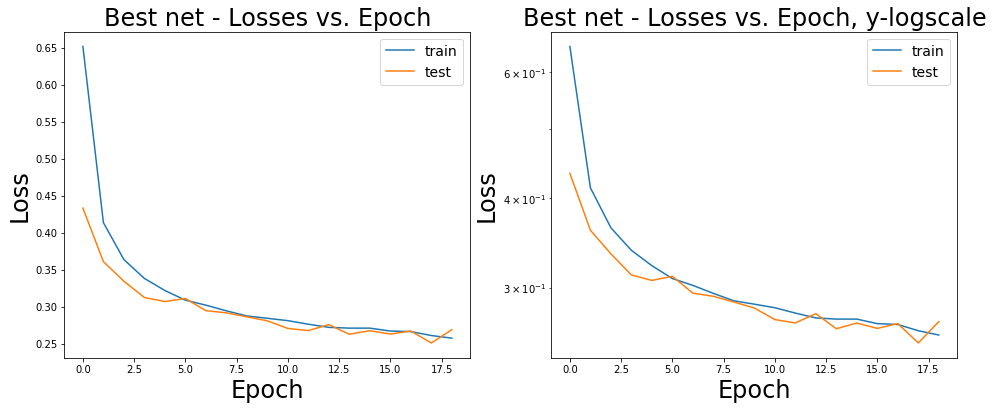

In [ ]:
# Plot training results
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_ylabel('Loss', fontsize=24)

ax[0].set_title('Best net - Losses vs. Epoch', fontsize=24)
ax[0].plot(best_train_loss, label='train')
ax[0].plot(best_test_loss, label='test')
ax[0].legend(loc='best', fontsize=14)

ax[1].set_title('Best net - Losses vs. Epoch, y-logscale', fontsize=24)
ax[1].semilogy(best_train_loss, label='train')
ax[1].semilogy(best_test_loss, label='test')
ax[1].legend(loc='best', fontsize=14)

plt.savefig('FashionMNIST_tr_test_loss_BEST.png')
plt.show()

In [ ]:
def testing(network, test_loader, loss_func, device):
    '''
    Define testing procedure, given a trained @network, a dataloader @test_loader and a loss function @loss_func.
    
    network:     trained network
    test_loader: test set dataloader 
    loss_func:   selected loss function
    device:      gpu (if available) or cpu
    
    Return: average test loss and test accuracy.        
    '''

    network.eval()  #set evaluation mode
    
    # define support variables
    corrects  = 0.
    totals    = 0.
    test_loss = 0.
    
    with torch.no_grad():
        for s_batch in test_loader:
            
            x_batch = s_batch[0].to(device)       #import data, move to device
            label_b = s_batch[1].to(device)       #import labels, move to device !!![1][0]????
            
            outputs = network(x_batch)
            
            test_loss += loss_func(outputs, label_b).item()
            
            _, predicted = torch.max(outputs.data, 1)
            totals += label_b.size(0)
            corrects += (predicted == label_b).sum().item()
        
        accuracy = (corrects / totals) * 100
        avg_test_loss = test_loss / totals
        
        print('\n Average test loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    avg_test_loss, corrects, totals, accuracy))
           
    return avg_test_loss, accuracy

final_avg_test_loss, accuracy = testing(final_net, test_loader, loss_func, device)


 Average test loss: 0.0021, Accuracy: 9006.0/10000.0 (90%)



In [ ]:
!pip install skorch

     |████████████████████████████████| 155 kB 12.3 MB/s 


Weights and filter visualization


In [ ]:
weights_CV1 = final_net.conv1.weight.data.cpu().numpy()
weights_CV2 = final_net.conv2.weight.data.cpu().numpy()

print(weights_CV2.shape)

(18, 9, 5, 5)


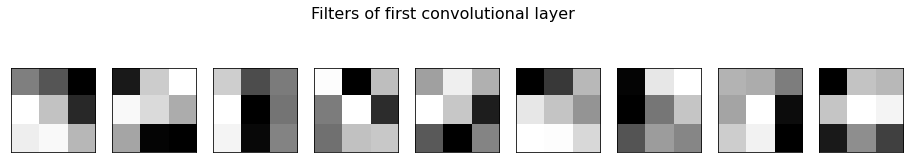

In [ ]:
fig, ax = plt.subplots(1,int(best_net['n_channels']), figsize=(16, 3))

for i in range(int(best_net['n_channels'])):
    ax[i].imshow( weights_CV1[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters of first convolutional layer', fontsize=16)
plt.savefig('filters_first_conv_layer.png')
plt.show()

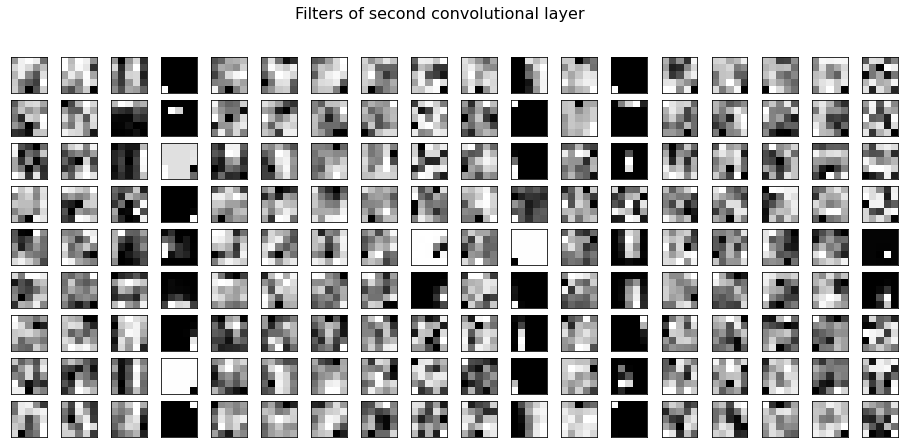

In [ ]:
fig, ax = plt.subplots(int(best_net['n_channels']), 2*int(best_net['n_channels']), figsize=(16, 7))

for i in range(int(best_net['n_channels'])):
    for j in range(2*int(best_net['n_channels'])):
        ax[i,j].imshow( weights_CV2[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
fig.suptitle('Filters of second convolutional layer', fontsize=16)
plt.savefig('filters_second_conv_layer.png')
plt.show()

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [ ]:
image_load = DataLoader(test_dataset, batch_size=1, shuffle=False) 

### Register hook  
hook_handle = final_net.conv1.register_forward_hook(get_activation)

### Analyze activations
net = final_net.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = final_net(x1)
        z1 = activation

### Remove hook
hook_handle.remove()

act1 = z1.cpu().numpy()
print(act1.shape)

(1, 9, 28, 28)


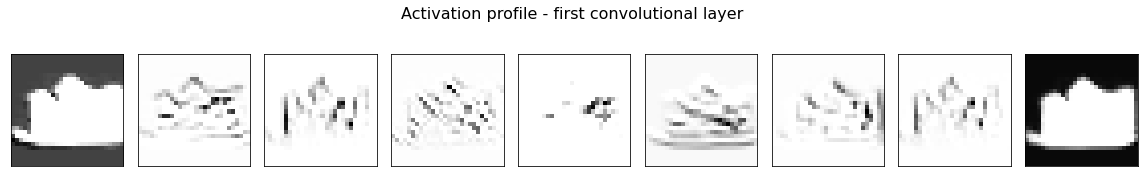

In [ ]:
## Plot activations
fig, ax = plt.subplots(1, int(best_net['n_channels']), figsize=(16,3))
for i in range(int(best_net['n_channels'])):
    ax[i].imshow( act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Activation profile - first convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_first_conv.png')
plt.show()   

In [ ]:
### Register hook  
hook_handle = final_net.conv2.register_forward_hook(get_activation)

### Analyze activations
net = final_net.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x2 = s_batch[0].to(device)
        # Forward pass
        y2 = final_net(x2)
        z2 = activation

### Remove hook
hook_handle.remove()

act2 = z2.cpu().numpy()
print(act2.shape)

(1, 18, 10, 10)


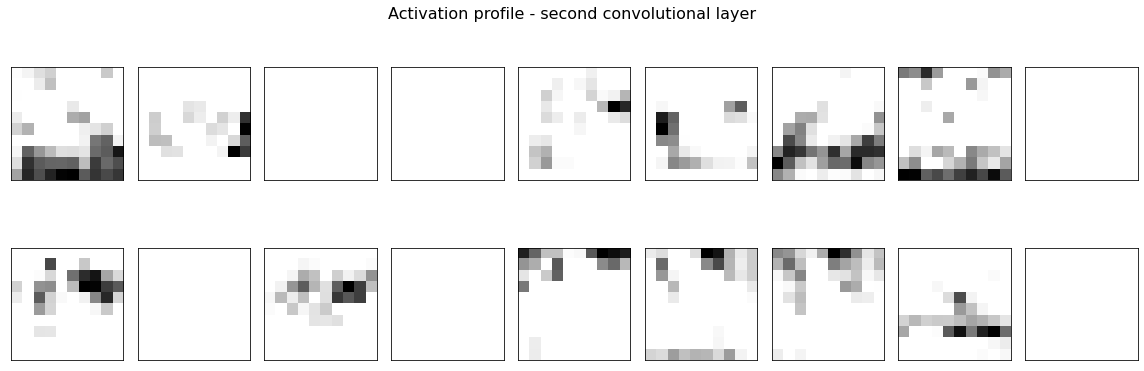

In [ ]:
## Plot activations
fig, ax = plt.subplots(2, int(best_net['n_channels']), figsize=(16,6))

for i in range(int(best_net['n_channels'])):
    ax[0, i].imshow( act2[0, i, :, :], cmap='Greys')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow( act2[0, i+int(best_net['n_channels']), :, :], cmap='Greys')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

fig.suptitle('Activation profile - second convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_second_conv.png')
plt.show()   

In [ ]:
K-fold cross validation

In [ ]:
#Best network parameters: {'num_epochs': 15.0, 'n_channels': 9.0, 'pdrop1d': 0.1662857764109922, 'pdrop2d': 0.14656503063798654, 'optimizer': 'adam', 'momentum': 0.626704227631114, 'learning_rate': 0.003197594206352734, 'reg_param': 0.0004986624637438257, 'final_loss': 0.25950103998184204, 'avg_train_loss': 0.31442153453826904, 'avg_valid_loss': 0.2916518449783325}
class CNN(nn.Module):
    '''
    Module including network structure and functioning, basic training, testing and validating operations.
    '''
    def __init__(self):
        '''
        The network is composed of:
        - one convolutional layer with 1 input channel, @n_channels output channels, a 3 by 3 kernel 
        - another convolutional layer with @n_channels input channels, 2*@n_channels output channels, 5 by 5 kernel
        - a dropout layer
        - one fully connected layer with (img size)x(2*n_channels)=50xn_channels inputs, 100 outputs
        - another dropout layer
        - one fully connected layer with 100 inputs, 10 outputs (corresponding to the 10 labels)  
        
        Input
        n_channels: number of convolutional channels
        pdrop2d:    dropout probability of 2D dropout layer
        pdrop1d:    dropout probability of 1D dropout layer
        '''
        super(CNN, self).__init__()
    
        # --> img size = 28-3+2*1+1= 28x28 
        self.conv1 = nn.Conv2d(1, 9, kernel_size=3, padding=1)
        # Max Pooling --> img size halved = 14x14
        self.mpool = nn.MaxPool2d(2, 2)    
        # dropout layer
        self.drop2 = nn.Dropout2d(p=0.14656503063798654) 
        # --> img size = 14-5+1 = 10x10
        self.conv2 = nn.Conv2d(9, 2*9, kernel_size=5) 
        # Max Pooling --> img size halved = 5x5
        
        # fully connceted layer with (img size)x(2*n_channels)=50xn_channels, 100 output units
        self.fulc1 = nn.Linear(50*9, 100)             
        # dropout after first linear layer
        self.drop1 = nn.Dropout(p=0.1662857764109922)
        # fully connected layer with inputs equal to number of outputs of previous layer, 10 outputs (10 digits)
        self.fulc2 = nn.Linear(100, 10)
        
        print('Network initialized')

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.mpool(x)
        x = F.relu(self.conv2(x))
        x = self.mpool(x)
        x = self.drop2(x)
        x = x.view(x.size(0), -1) # reshaping necessary for linear layer
        x = F.relu(self.fulc1(x))
        x = self.drop1(x)
        x = self.fulc2(x)
        
        return x

In [ ]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
def train(fold, self, train_loader, optimizer, loss_func, device, epoch, verbose=False):
        """
        Define the basic train step.
        
        train_loader: dataloader
        optimizer:    type of selected optimizer (SGD, Adam...)
        loss_func:    selected loss function
        device:       gpu (if available) or cpu
        epoch:        number of epoch in training process
        verbose:      if True prints out status of training process, default False
        
        Return: training loss.
        """
        
        train_loss = [] #initialize vector containing training losses
        self.train()    #set training mode
        
        for ii, s_batch in enumerate(train_loader):
            
            x_batch = s_batch[0].to(device)       #import data, move to device 
            label_b = s_batch[1].to(device)       #import labels, move to device
            
            for_out = self.forward(x_batch)       #forward pass
            
            tr_loss = loss_func(for_out, label_b) #compute loss
        
            self.zero_grad()                      #back-propagation
            tr_loss.backward()
            
            optimizer.step()                      #weights update
                
            ba_loss = tr_loss.detach().cpu().numpy()
            train_loss.append(ba_loss)            #save loss for batch
            
            if (ii % 10 == 0 and verbose): # every 10 batches print out a sumary of training results
                print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(fold,epoch, ii * len(s_batch[0]), len(train_loader.dataset),
                100. * ii / len(train_loader), ba_loss)) 

In [ ]:
def test(fold,network, test_loader, loss_func, device):
    '''
    Define testing procedure, given a trained @network, a dataloader @test_loader and a loss function @loss_func.
    
    network:     trained network
    test_loader: test set dataloader 
    loss_func:   selected loss function
    device:      gpu (if available) or cpu
    
    Return: average test loss and test accuracy.        
    '''

    network.eval()  #set evaluation mode
    
    # define support variables
    corrects  = 0.
    totals    = 0.
    test_loss = 0.
    
    with torch.no_grad():
        for s_batch in test_loader:
            
            x_batch = s_batch[0].to(device)       #import data, move to device
            label_b = s_batch[1].to(device)       #import labels, move to device !!![1][0]????
            
            outputs = network(x_batch)
            
            test_loss += loss_func(outputs, label_b).item()
            
            _, predicted = torch.max(outputs.data, 1)
            totals += label_b.size(0)
            corrects += (predicted == label_b).sum().item()
        
        accuracy = (corrects / totals) * 100
        avg_test_loss = test_loss / totals
        
        print('\nTest set for fold {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        fold,avg_test_loss, corrects, totals, accuracy))  
  

In [ ]:
model = CNN().to(device)
model.apply(reset_weights)
loss_func = nn.CrossEntropyLoss() 

Network initialized


In [ ]:
batch_size=192
k_folds=5
epochs=5

kfold=KFold(n_splits=k_folds,shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.00319, 
                     weight_decay=0.0004)

In [ ]:
dataset=ConcatDataset([train_dataset,test_dataset])

In [ ]:
for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
  print('------------fold no---------{}----------------------'.format(fold))
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

  trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)

  model.apply(reset_weights)

  for epoch in range(1, epochs + 1):
    train(fold, model, train_loader, optimizer, loss_func, device, epoch)
    test(fold,model, test_loader, loss_func, device)

------------fold no---------0----------------------

Test set for fold 0: Average loss: 0.0034, Accuracy: 8420.0/10000.0 (84%)


Test set for fold 0: Average loss: 0.0029, Accuracy: 8646.0/10000.0 (86%)


Test set for fold 0: Average loss: 0.0026, Accuracy: 8767.0/10000.0 (88%)


Test set for fold 0: Average loss: 0.0025, Accuracy: 8807.0/10000.0 (88%)


Test set for fold 0: Average loss: 0.0024, Accuracy: 8854.0/10000.0 (89%)

------------fold no---------1----------------------

Test set for fold 1: Average loss: 0.0032, Accuracy: 8448.0/10000.0 (84%)


Test set for fold 1: Average loss: 0.0027, Accuracy: 8696.0/10000.0 (87%)


Test set for fold 1: Average loss: 0.0026, Accuracy: 8808.0/10000.0 (88%)


Test set for fold 1: Average loss: 0.0024, Accuracy: 8865.0/10000.0 (89%)


Test set for fold 1: Average loss: 0.0024, Accuracy: 8857.0/10000.0 (89%)

------------fold no---------2----------------------

Test set for fold 2: Average loss: 0.0032, Accuracy: 8443.0/10000.0 (84%)


Test se

VGG MODEL 

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(nn.Linear(256, num_classes))

      if init_weights:
        self.initialize_weights()
  
  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 

cfgs: Dict[str, List[Union[int, str]]] = {
    'A':[64, 'M', 128, 128, 'M', 256, 256, 256],
    'B':[16, 'M', 256, 'M'],
    'firstPadding':2
}
# cfgs: Dict[str, List[Union[str, int]]] = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }



def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Moduel] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 10)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

In [ ]:
loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size),
    'val': torch.utils.data.DataLoader(val_data, batch_size=batch_size)
}


In [ ]:
#for metrics
dataset_sizes = { 'train': len(train_data), 'val': len(val_data)}

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [ ]:
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.46436321645975115, accuracy0.8325416666666666
val - loss:1.0896425218582153, accuracy0.6626666666666666
Time: 0.0m 35.31567406654358s
Epoch: 2/10
train - loss:0.2851098623275757, accuracy0.89625
val - loss:0.3055142332315445, accuracy0.8891666666666667
Time: 1.0m 10.696027755737305s
Epoch: 3/10
train - loss:0.23292243561148643, accuracy0.9159999999999999
val - loss:0.3332495367527008, accuracy0.8801666666666667
Time: 1.0m 45.7446551322937s
Epoch: 4/10
train - loss:0.19420810258388518, accuracy0.92925
val - loss:0.45327031207084656, accuracy0.8501666666666666
Time: 2.0m 20.920247554779053s
Epoch: 5/10
train - loss:0.1280234045535326, accuracy0.9554374999999999
val - loss:0.20081253147125244, accuracy0.9269166666666666
Time: 2.0m 55.90004873275757s
Epoch: 6/10
train - loss:0.10540380032360554, accuracy0.9643125
val - loss:0.20199303317070008, accuracy0.9269166666666666
Time: 3.0m 30.977224588394165s
Epoch: 7/10
train - loss:0.0892696782797575, accuracy0.9704166

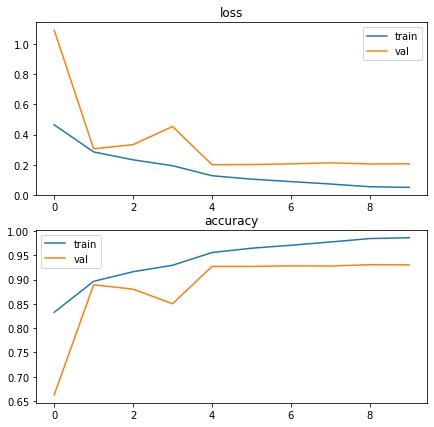

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], accuracies['train'], label ='train')
axs[1].plot([x for x in range(epochs)], accuracies['val'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

In [ ]:
corr = 0
 
with torch.no_grad(): 
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images) 
        _, predicted = torch.max(y_pred, 1) 
        corr += torch.sum(predicted == labels.data)
 
print(f"Test accuracy: {corr/len(test_dataset)}")

Test accuracy: 0.9264999628067017
